In [508]:
import numpy as np
import matplotlib as mpl
mpl.use("Agg")
from matplotlib import rc
#rc('font',**{'family':'serif'})
#rc('text', usetex=True)
from matplotlib import pyplot as plt
%matplotlib notebook

In [509]:
BENCHMARKS_DIR = 'bifrost/test/benchmarks/'
SERIAL_BENCHMARKS_DIR = BENCHMARKS_DIR + 'performance_vs_serial/'

In [510]:
i_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': 2,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': 4,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

In [511]:
def have_same_parameters(X, parameter_slice):
    index_selection = []
    for key in parameter_slice:
        index_selection.append(X[:, i_map[key]] == parameter_slice[key])
    
    return X[np.prod(index_selection, axis=0).astype(bool)]

In [512]:
aws_benchmarks = []
# 5 is the original!
n_files = 15
for n in range(1, n_files+1):
    benchmarks_file = open(SERIAL_BENCHMARKS_DIR + 'new_ben_bench/ben_bench_'+str(n)+'.log.txt', 'r')
    # FFT's/2, size multiplier, gulp size, gulp frame read, gulp frame fft, ..., ..., speedup
    # WARN: Some values are np.nan! Approximately 3 rows in the first 46 files. (23, 31, 33)
    aws_benchmarks.append(np.genfromtxt(
        (",".join(ln.split(',')[1:-1]) for ln in benchmarks_file),
        dtype=np.float32,
        filling_values=np.nan,
        delimiter=','));
    
#Put all trials together
aws_benchmarks = np.concatenate([aws_benchmarks[i] for i in range(n_files)])

#Delete Nan rows
nan_rows = np.unique(np.argwhere(np.isnan(aws_benchmarks))[:, 0])
aws_benchmarks = np.delete(aws_benchmarks, nan_rows, axis=0)

#Sort based on parameters
aws_benchmarks = aws_benchmarks[np.lexsort([aws_benchmarks[:, i] for i in range(5)])]

#Load up all possible parameters:
parameter_keys = ['fft_number', 'gulp_size', 'gulp_nframe_read', 'gulp_nframe_fft']
parameter_options = {}
parameter_num_options = {}
for key in parameter_keys:
    parameter_options[key] = np.unique(aws_benchmarks[:, i_map[key]])
    parameter_num_options[key] = len(parameter_options[key])


In [514]:
aws_benchmarks.shape

(4496, 8)

In [527]:
from itertools import product
jj = 0
N = 10
rangees = []
for x in product(*[range(parameter_num_options[key]) for key in parameter_keys]):
    curr_options = {key:parameter_options[key][x[i]] for i, key in enumerate(parameter_keys)}
    data = have_same_parameters(aws_benchmarks,
                     curr_options)

    #for q in [data[:, i_map['bf_time']], data[:, i_map['sk_time']]]:
    q = np.copy(data[:, i_map['bf_time']])
    #q = q[np.argsort(q)]
    #qq = q/np.std(q)
    #qqq = qq - np.average(qq)
    rangee = np.max(q) - np.min(q)
    rangees.append(rangee)
    #if abs(rangee - 0.01) < 0.01:
        #print curr_options
    #fig = plt.figure()
    #plt.hist(q, bins=10)
    #fig.savefig(str(jj)+'histogram.png')
    #fig.clf()
    jj += 1
    if jj > N:
        break

In [526]:
#plt.hist(np.array(rangees)[np.array(rangees)<0.5], bins=50)

# Combine data with simple averaging:

In [ ]:
have_same

In [551]:
new_bench_with_error = []
i_map_er = {
    'bf_time_er': 8,
    'sk_time_er': 9,
    'speedup_er': 10
}

def speedup_er(sk_time, sk_time_er, bf_time, bf_time_er, speedup):
    return speedup*np.sqrt(
        sk_time_er**2./sk_time**2. +
        bf_time_er**2./bf_time**2.
    )

for jj, x in enumerate(product(*[range(parameter_num_options[key]) for key in parameter_keys])):
    curr_options = {key:parameter_options[key][x[i]] for i, key in enumerate(parameter_keys)}
    data = have_same_parameters(aws_benchmarks,
                     curr_options)
    
    new_bench_with_error.append(list(data[0]))
    
    for key in ['bf_time', 'sk_time']:
        new_bench_with_error[jj][i_map[key]] = np.average(data[:, i_map[key]])
        new_bench_with_error[jj].append(np.std(data[:, i_map[key]]))
    
    # Recalculate speedup:
    new_bench_with_error[jj][i_map['speedup']] = \
        new_bench_with_error[jj][i_map['sk_time']]/new_bench_with_error[jj][i_map['bf_time']]
    
    # Error on speedup
    new_bench_with_error[jj].append(
        speedup_er(
            *[new_bench_with_error[jj][i] for i in [
                i_map['sk_time'],
                i_map_er['sk_time_er'],
                i_map['bf_time'],
                i_map_er['bf_time_er'],
                i_map['speedup']
            ]]))

new_bench_with_error = np.array(new_bench_with_error)

# Log2 the data, and extract a slice for plotting:

In [553]:
cur_benchmarks = np.copy(new_bench_with_error)
cur_benchmarks[:, i_map['gulp_size']] = np.log2(cur_benchmarks[:, i_map['gulp_size']]/32768)
cur_benchmarks[:, i_map['gulp_nframe_read']] = np.log2(cur_benchmarks[:, i_map['gulp_nframe_read']])
cur_benchmarks[:, i_map['gulp_nframe_fft']] = np.log2(cur_benchmarks[:, i_map['gulp_nframe_fft']])

# Create a data slice:

In [554]:
data_slice = {
    'fft_number': 1,
    'size_multiplier': 1,
    'gulp_nframe_read': np.log2(2)
}

index_possible_choices = [cur_benchmarks[:, i_map[key]] == data_slice[key] for key in data_slice.keys()]

index_shared_choices = np.bitwise_and.reduce(index_possible_choices)

indices = np.argwhere(index_shared_choices[:]) #works.

# Get ready to plot it:

In [555]:
x_axis = 'gulp_size' #second of [1, 2]
y_axis = 'gulp_nframe_fft' #first of [1, 2]

data_to_plot = cur_benchmarks[indices, [i_map[y_axis], i_map[x_axis], i_map['speedup']]]

range_array = lambda ar: np.max(ar) - np.min(ar)

shape_display_y = int(range_array(data_to_plot[:, 0]) + 1)
shape_display_x = int(range_array(data_to_plot[:, 1]) + 1)

# Last axis is always x-axis in an imshow!
plot_shape = (shape_display_y, shape_display_x)

display_plot = np.zeros(plot_shape)

display_plot[data_to_plot[:, 0].astype(np.int), data_to_plot[:, 1].astype(np.int)] = data_to_plot[:, 2]

# Plot the data:

<IPython.core.display.Javascript object>


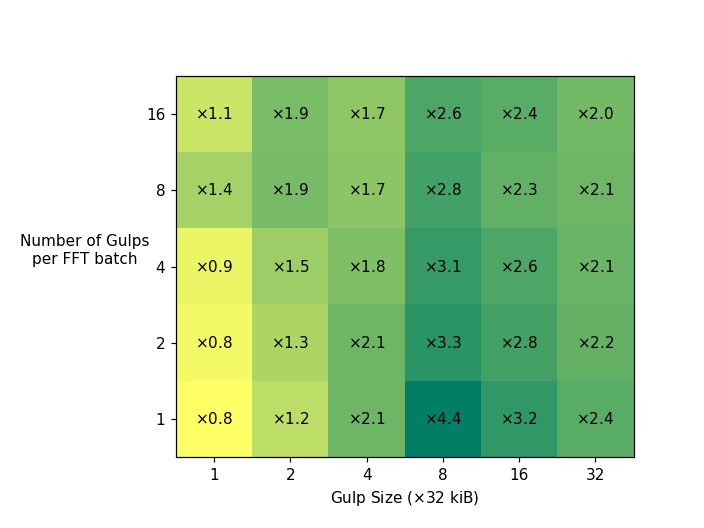

In [556]:
%matplotlib notebook

fig, ax1 = plt.subplots(1,1)
from matplotlib.colors import LogNorm

# Title:
title_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': "Gulp Size"r" ($\times$32 kiB)",
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': "Number of Gulps\nper FFT batch",
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Title:
tick_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': lambda i: 2**i,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': lambda i: 2**i,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Log color scale
norm = LogNorm(vmin=np.min(display_plot), vmax=np.max(display_plot))

im = ax1.imshow(
    display_plot,
    cmap='summer_r', origin='lower', norm=norm)
ax1.set_ylabel(title_map[y_axis], rotation=0, labelpad=40)
ax1.set_xlabel(title_map[x_axis]);

ax1.set_xticks([i for i in range(display_plot.shape[1])])
ax1.set_yticks([i for i in range(display_plot.shape[0])])
ax1.set_xticklabels([tick_map[x_axis](i) for i in range(display_plot.shape[1])])
ax1.set_yticklabels([tick_map[y_axis](i) for i in range(display_plot.shape[0])])

"""
ax1.set_xticks([i for i in range(5)])
ax1.set_xticklabels([2**i for i in range(1, 6)])
ax1.set_xlabel(r'Gulp Size ($\times$128 kiB)')
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_yticklabels([1, 2, 4, 8, 16])
ax1.set_ylabel(r'Number Gulps''\n'r'per batch',rotation=0, labelpad=40)
cbar = fig.colorbar(im, shrink=0.4, ticks=[np.min(rel_display_plot), 1.0, 2])
cbar.ax.set_yticklabels(['Slower', 'Same', 'Faster'])  # vertically oriented colorbar
cbar.ax.text(13, 0.4, 'Speedup\nvs.\nskcuda', rotation=0, 
        horizontalalignment='center')

fig.savefig('bifrost/speedup.pdf', bbox_inches='tight')
""";

for (j,i),label in np.ndenumerate(display_plot):
    ax1.text(i, j, r'$\times$%.1f'%label, ha='center', va='center')
fig.subplots_adjust(left=0.25)

# Functions:

In [557]:
title_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': "Gulp Size"r" ($\times$32 kiB)",
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': "Gulps per\nFFT Batch",
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Title:
tick_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': lambda i: 2**i,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': lambda i: 2**i,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

i_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': 2,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': 4,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

def clean_array(array):
    cur_benchmarks = np.copy(array)
    cur_benchmarks[:, i_map['gulp_size']] = np.log2(cur_benchmarks[:, i_map['gulp_size']]/32768)
    cur_benchmarks[:, i_map['gulp_nframe_fft']] = np.log2(cur_benchmarks[:, i_map['gulp_nframe_fft']])
    
    return cur_benchmarks

def create_slice(dict_slice, array):
    index_possible_choices = [array[:, i_map[key]] == data_slice[key] for key in data_slice.keys()]
    index_shared_choices = np.bitwise_and.reduce(index_possible_choices)
    indices = np.argwhere(index_shared_choices[:]) #works.
    
    return indices

def extract_data(indices, x_axis, y_axis, array, z_axis):
    data_to_plot = np.copy(array[indices, [i_map[y_axis], i_map[x_axis], i_map[z_axis]]])
    range_array = lambda ar: np.max(ar) - np.min(ar)
    shape_display_y = int(range_array(data_to_plot[:, 0]) + 1)
    shape_display_x = int(range_array(data_to_plot[:, 1]) + 1)
    # Last axis is always x-axis in an imshow!
    plot_shape = (shape_display_y, shape_display_x)
    display_plot = np.zeros(plot_shape)
    display_plot[data_to_plot[:, 0].astype(np.int), data_to_plot[:, 1].astype(np.int)] = data_to_plot[:, 2]
    
    return display_plot


# Experiment:

<IPython.core.display.Javascript object>


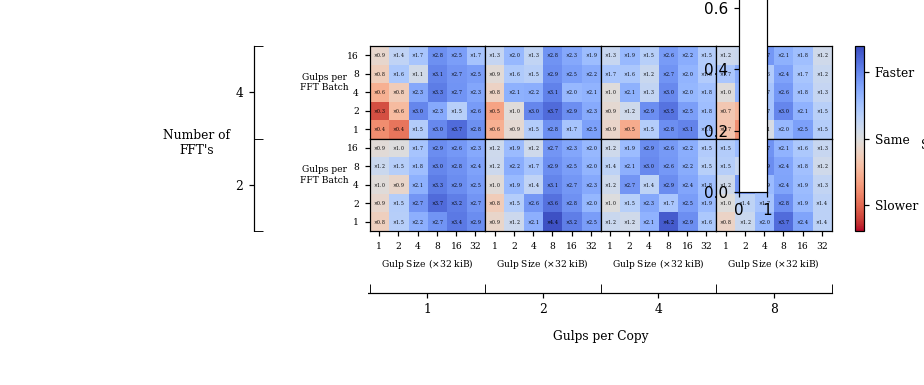

<IPython.core.display.Javascript object>


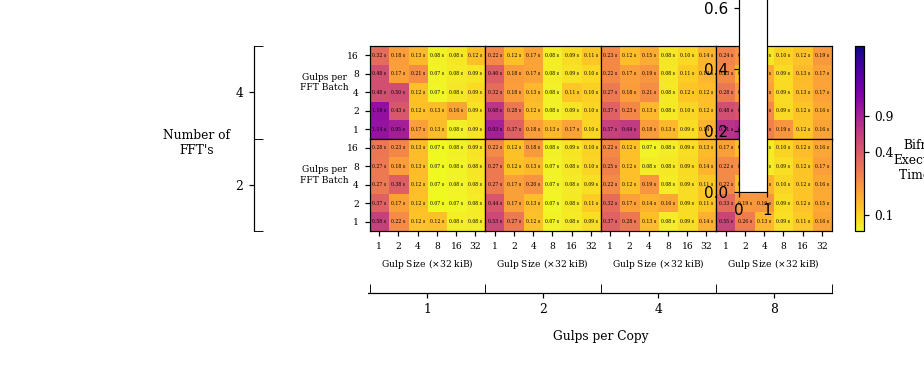

<IPython.core.display.Javascript object>


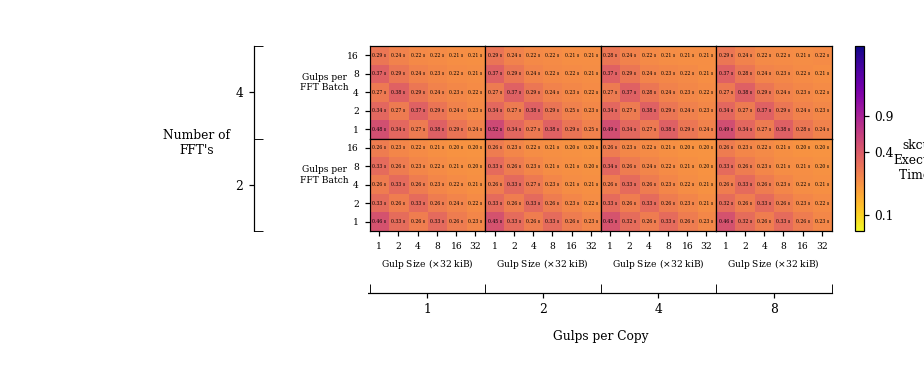

In [560]:
%matplotlib notebook
# Log color scale
from matplotlib.colors import LogNorm
#for z_axis in ['speedup']:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

for z_axis in ['speedup', 'bf_time', 'sk_time']:
    ax_outside = fig.add_axes([0.8, 0.5, 0.03, 0.8])

    norm = []
    if z_axis == 'speedup':
        min_speedup = np.min(aws_benchmarks[:,i_map[z_axis]])
        max_speedup = np.max(aws_benchmarks[:,i_map[z_axis]])
        
        norm = LogNorm(
            vmin=np.exp(-np.log(max_speedup)),
            vmax=max_speedup)
    else:
        norm = LogNorm(
            vmin=np.min([np.min(aws_benchmarks[:,i_map['bf_time']]),np.min(aws_benchmarks[:,i_map['sk_time']])]),
            vmax=np.max([np.max(aws_benchmarks[:,i_map['bf_time']]),np.max(aws_benchmarks[:,i_map['sk_time']])]))

    fig = plt.figure(figsize = np.array([6*2,5])*0.7)

    axes = []
    ims = []
    small_font = 3
    normal_font = 6
    for ax in range(8):
        ax1 = {
            0: plt.subplot(2,4,1), #top left
            1: plt.subplot(2,4,2), #middle top left
            2: plt.subplot(2,4,5), #bottom left
            3: plt.subplot(2,4,6), #middle bottom left
            4: plt.subplot(2,4,3), #middle top right
            5: plt.subplot(2,4,4), #top right
            6: plt.subplot(2,4,7), #middle bottom right
            7: plt.subplot(2,4,8), #bottom right
        }[ax]

        axes.append(ax1)

        # Top of plots are FFT=2, bottom is FFT=1 (total blocks)
        # from left to right, number of gulps in nframe read increases
        data_slice = {
            'fft_number': {0:2, 2:1,
                           1:2, 3:1,
                           4:2, 6:1,
                           5:2, 7:1}[ax],
            'size_multiplier': 1,
            'gulp_nframe_read': {0:1, 2:1,
                                 1:2, 3:2,
                                 4:4, 6:4,
                                 5:8, 7:8}[ax],
        }
        #############################################################
        #####################These should be 1-8 instead of 2-16! as faster.
        #############################################################
        x_axis = 'gulp_size'
        y_axis = 'gulp_nframe_fft'

        cur_benchmarks = clean_array(aws_benchmarks)
        indices = create_slice(data_slice, cur_benchmarks)
        display_plot = extract_data(indices, x_axis, y_axis, cur_benchmarks, z_axis)


        im = ax1.imshow(
            display_plot,
            cmap={'speedup':'coolwarm_r', 'bf_time':'plasma_r', 'sk_time':'plasma_r'}[z_axis],
            origin='lower', norm=norm)
        ims.append(im)
        
        for (j,i),label in np.ndenumerate(display_plot):
            if z_axis == 'speedup':
                ax1.text(i, j, r'$\times$%.1f'%label, ha='center', va='center', fontname='serif', fontsize=small_font)
            else:
                ax1.text(i, j, r'%.2f s'%label, ha='center', va='center', fontname='serif', fontsize=small_font)
        if ax == 2:
            ax1.set_ylabel(title_map[y_axis], rotation=0, labelpad=15, fontname='serif', fontsize=normal_font)
            ax1.set_xlabel(title_map[x_axis], fontname='serif', fontsize=normal_font);
            ax1.set_xticks([i for i in range(display_plot.shape[1])])
            ax1.set_yticks([i for i in range(display_plot.shape[0])])
            ax1.set_xticklabels([str(tick_map[x_axis](i)) for i in range(display_plot.shape[1])], fontname='serif', fontsize=normal_font)
            ax1.set_yticklabels([str(tick_map[y_axis](i)) for i in range(display_plot.shape[0])], fontname='serif', fontsize=normal_font)
        elif ax == 0:
            ax1.set_ylabel(title_map[y_axis], rotation=0, labelpad=15, fontname='serif', fontsize=normal_font)
            ax1.set_yticks([i for i in range(display_plot.shape[0])])
            ax1.set_yticklabels([str(tick_map[y_axis](i)) for i in range(display_plot.shape[0])], fontname='serif', fontsize=normal_font)
            ax1.set_xticks([])
            
        elif ax == 3 or ax == 6 or ax == 7:
            ax1.set_xlabel(title_map[x_axis], fontname='serif', fontsize=normal_font);
            ax1.set_xticks([i for i in range(display_plot.shape[1])])
            ax1.set_xticklabels([str(tick_map[x_axis](i)) for i in range(display_plot.shape[1])], fontname='serif', fontsize=normal_font)
            ax1.set_yticks([])
        else:
            ax1.set_xticks([])
            ax1.set_yticks([])


        ax1.set_aspect('auto')
        

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    #gs1.update(wspace=0, hspace=0) # set the spacing between axes.
    #mpl.lines()
    fig.subplots_adjust(left=0.4, bottom=0.4)

    pos1 = axes[2].get_position()

    ax_bg = plt.axes(
        [pos1.x0-pos1.width*1.0,pos1.y0-pos1.height/1.5, pos1.width*(4.+1.0), pos1.height*(2.+1./1.5)],
        facecolor=(1,1,1,0))

    ax_bg.set_xticks(np.array([1.5, 2.5, 3.5, 4.5])/5.0)
    ax_bg.set_xticklabels([str(i) for i in [1, 2, 4, 8]], family='serif', fontsize=8)
    ax_bg.set_yticks(np.array([1./1.5+0.5, 1.5+1./1.5])/(2.+1./1.5))
    ax_bg.set_yticklabels([str(i) for i in [2, 4]], family='serif', fontsize=8)

    ax_bg.spines['top'].set_visible(False)
    ax_bg.spines['right'].set_visible(False)

    ax_bg.set_xlabel("Gulps per Copy", family='serif', fontsize=8)
    ax_bg.set_ylabel("Number of\nFFT's", rotation=0, family='serif', fontsize=8)
    ax_bg.yaxis.set_label_coords(-0.1,0.55)
    ax_bg.xaxis.set_label_coords(0.6, -0.15)

    from matplotlib.ticker import FixedLocator, FormatStrFormatter
    ax_bg.xaxis.set_minor_locator(FixedLocator((np.array([1.5, 2.5, 3.5, 4.5, 5.5]) - 0.5)/5.0))
    ax_bg.xaxis.set_tick_params(which='minor', direction='in', length=6)
    ax_bg.xaxis.set_tick_params(which='major', direction='out')

    ax_bg.yaxis.set_minor_locator(FixedLocator((np.array([1./1.5+0.5, 1.5+1./1.5, 2.5+1./1.5]) - 0.5)/(2.+1./1.5)))
    ax_bg.yaxis.set_tick_params(which='minor', direction='in', length=6)
    ax_bg.yaxis.set_tick_params(which='major', direction='out')

    ax_bg_bg = fig.add_axes([0,0,1,1])
    ax_bg_bg.xaxis.set_visible(False)
    ax_bg_bg.yaxis.set_visible(False)
    ax_bg_bg.set_zorder(1000)
    ax_bg_bg.patch.set_alpha(0.0)
    
    ax_bg_bg.spines['top'].set_visible(False)
    ax_bg_bg.spines['bottom'].set_visible(False)
    ax_bg_bg.spines['left'].set_visible(False)
    ax_bg_bg.spines['right'].set_visible(False)

    rect = mpl.patches.Rectangle(
        (ax_bg.get_position().x0-pos1.width*1.0, ax_bg.get_position().y0-pos1.height*1),
        pos1.width*(1.0+.99), pos1.height*(1./1.5+0.99),
        linewidth=0, color='white')
    # Add the patch to the Axes
    ax_bg_bg.add_patch(rect)
    
    ax_outside = fig.add_axes([pos1.x0 + pos1.width*4.2, pos1.y0, 0.01, pos1.height*2.])
    if z_axis == 'speedup':
        cb = fig.colorbar(ims[0], cax=ax_outside, format=FormatStrFormatter("%.1f"))
        cb.set_ticks([1.0/3.0, 1.0, 3.0])
        cb.ax.set_yticklabels(["Slower", "Same", "Faster"], fontname='serif', fontsize=8)
        cb.ax.set_ylabel("Speedup\nvs.\nskcuda", fontname='serif', fontsize=8, rotation=0, labelpad=20)
    else:
        cb = fig.colorbar(ims[0], cax=ax_outside, format=FormatStrFormatter("%.2f"))
        cb.set_ticks([0.10, 0.40, 0.90])
        cb.ax.set_yticklabels([0.10, 0.40, 0.90], fontname='serif', fontsize=8)
        if z_axis == 'bf_time':
            cb.ax.set_ylabel("Bifrost\nExecution\nTime (s)", fontname='serif', fontsize=8, rotation=0, labelpad=20)
        else:
            cb.ax.set_ylabel("skcuda\nExecution\nTime (s)", fontname='serif', fontsize=8, rotation=0, labelpad=20)
    
    
    fig.savefig(z_axis+".pdf", bbox_inches='tight')
    


# Now, cut off the edges:

In [248]:
%%bash
/usr/texbin/pdfcrop --bbox "100 20 680 250" speedup.pdf speedup_cropped.pdf
/usr/texbin/pdfcrop --bbox "100 20 680 250" bf_time.pdf bf_time_cropped.pdf
/usr/texbin/pdfcrop --bbox "100 20 680 250" sk_time.pdf sk_time_cropped.pdf
#"/System/Library/Automator/Combine PDF Pages.action/Contents/Resources/join.py" -o merged.pdf *_cropped.pdf
pdfjam sk_time_cropped.pdf bf_time_cropped.pdf --nup 1x2 --landscape --outfile merged.pdf
/usr/texbin/pdfcrop merged.pdf merged_cropped.pdf
/usr/texbin/pdfcrop speedup.pdf speedup_cropped.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `speedup_cropped.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `bf_time_cropped.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `sk_time_cropped.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `merged_cropped.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `speedup_cropped.pdf'.


          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /usr/texbin/pdfjam --nup '1x2' --landscape --outfile merged.pdf -- sk_time_cropped.pdf - bf_time_cropped.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'merged.pdf'.


# Caption ideas

Should emphasize:
- This pipeline was not tuned in any way, it is vanilla Bifrost code, with no core bindings set, and no block fusion enabled.
- Not only do you get more speed for same effort, but you get greater functionality for same effort (bf.map!)
- Easy to switch it to a real-time pipeline for a telescope
- These plots aren't meant to show anything particular about when Bifrost is useful and when it isn't, they are supposed to show the trend of where Bifrost becomes very effective: large gulp sizes and large amounts of data.
- Bottom slower for Bifrost because of the greater Python overhead incurred from small gulp sizes. Small effort tuning gulp sizes eliminates this.
- Both pipelines are GPU-based FFT pipelines, controlled in Python. Similar (say exactly) source lines of code. Through pipeline-parallelism, Bifrost achieves a speedup using the same underlying cuFFT functionality.
- Emphasize that a hand-tuned C or C++ pipeline compiled with optimization can be faster than Bifrost. However, due to the development effort associated with writing a stream-processing pipeline by hand, Bifrost is a competitive alternative.

# For testing, let's see what a parallel axis figure looks like:

In [249]:
import pandas as pd
from pandas.plotting import parallel_coordinates

In [250]:
pd_data = pd.DataFrame(data=np.copy(cur_benchmarks),
             columns="FFT's/2,size multiplier,gulp size,gulp frame read,gulp frame fft,bifrost time,skcuda time,speedup".split(','),
             index=[i for i in range(cur_benchmarks.shape[0])]);

In [268]:
pd_data = pd.DataFrame(data=np.copy(cur_benchmarks),
             columns="FFT's/2,size multiplier,gulp size,gulp frame read,gulp frame fft,bifrost time,skcuda time,speedup".split(','),
             index=[i for i in range(cur_benchmarks.shape[0])]);
#del pd_data['size multiplier']
#del pd_data['bifrost time']
#del pd_data['skcuda time']
#del pd_data["FFT's/2"]
up = 0.07
pd_data['gulp size'][:] += (pd_data['speedup'][:]-np.average(pd_data['speedup']))*up
pd_data['gulp frame fft'][:] += (pd_data['speedup'][:]-np.average(pd_data['speedup']))*up
pd_data['gulp frame read']  = np.log2(pd_data['gulp frame read'])
pd_data['gulp frame read'][:] += (pd_data['speedup'][:]-np.average(pd_data['speedup']))*up
pd_data["FFT's/2"][:] += (pd_data['speedup'][:]-np.average(pd_data['speedup']))*up

In [269]:
pd_data['bifrost time']

0      0.075677
1      0.076838
2      0.080140
3      0.086074
4      0.084135
5      0.077985
6      0.078165
7      0.074473
8      0.096369
9      0.127512
10     0.132490
11     0.125471
12     0.084723
13     0.093036
14     0.081528
15     0.133666
16     0.092997
17     0.081472
18     0.073118
19     0.074793
20     0.135524
21     0.133327
22     0.079040
23     0.075368
24     0.082890
25     0.121093
26     0.121447
27     0.077147
28     0.080603
29     0.083157
         ...   
270    0.382883
271    0.281855
272    0.369229
273    0.372739
274    0.374221
275    0.323661
276    0.297033
277    0.268359
278    0.264858
279    0.268155
280    0.323982
281    0.255674
282    0.322123
283    0.262522
284    0.321726
285    0.603112
286    0.327724
287    0.337297
288    0.624636
289    0.264838
290    0.334866
291    0.262175
292    0.626003
293    0.283297
294    0.373466
295    0.292994
296    0.674476
297    0.527733
298    0.778791
299    0.781391
Name: bifrost time, Leng

In [270]:
colors = [[1.0-i/np.max(pd_data['speedup']), i/np.max(pd_data['speedup']), 0.0, 0.5] for i in pd_data['speedup']]
#colors = [[i[0], i[1], (-1.*np.min(pd_data['gulp size']) + pd_data['gulp size'][x]/6.0)/2.0, 0.2] for x,i in enumerate(colors)]

<IPython.core.display.Javascript object>


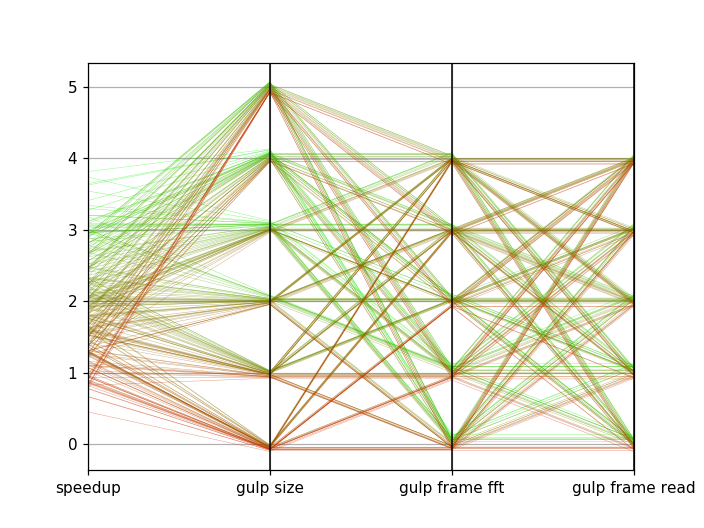

In [271]:
fig = plt.figure()
parallel_coordinates(pd_data,
                     "speedup",
                     cols="speedup,gulp size,gulp frame fft,gulp frame read".split(','),
                     color=colors,
                     linewidth=0.3)
plt.gca().legend_.remove()
fig.savefig("parallel.pdf")

In [83]:
parallel_coordinates?